## Preprocessing ECG signals

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ptbxl.utils.paths import data_interim_dir, data_raw_dir
from ptbxl.data.make_dataset import load_raw_data
from ptbxl.data.signal_preprocessing import SignalPreprocessing

sns.set_theme()

preprocessing = SignalPreprocessing()

In [3]:
# Load metatadata
dataset_metadata = pd.read_csv(data_interim_dir("dataset_metadata.csv"))
print(f"Number of records: {len(dataset_metadata)}")
display(dataset_metadata.head())

Number of records: 9553


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,max_likelihood,target
0,17,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 14:25:25,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00017_lr,records500/00000/00017_hr,AFLT,1.0
1,18,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-20 15:17:24,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00018_lr,records500/00000/00018_hr,AFLT,1.0
2,20,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-23 12:55:32,...,NaN,NaN,NaN,VES,NaN,9,records100/00000/00020_lr,records500/00000/00020_hr,AFLT,1.0
3,23,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-25 12:49:40,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00023_lr,records500/00000/00023_hr,AFLT,1.0
4,34,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-10 12:04:03,...,", alles,",NaN,NaN,NaN,NaN,9,records100/00000/00034_lr,records500/00000/00034_hr,AFLT,1.0


## Load ECG signals

- $m$: is the number of patients
- $n$: is the length of the signal
- Lead: are the number of channels. In this case 12

In [4]:
# Leads names
leads = ['I', 'II', 'III', 'aVF', 'aVR', 'aVL', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [5]:
fs = 100 # Sampling rate (Hz)
ecg_signals = load_raw_data(
    dataset_metadata, 
    sampling_rate=fs, 
    path=data_raw_dir("physionet.org/files/ptb-xl/1.0.3"),
)

m, n, lead = ecg_signals_data_shape = ecg_signals.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

print(f"Signald block shape (m, n, lead): {ecg_signals_data_shape}")
print(f"Signals duration: {dur}")

Signald block shape (m, n, lead): (9553, 1000, 12)
Signals duration: 10.0


## Remove first and last second of the ECGs

In [6]:
ecg_signals = ecg_signals[:, 1*fs:-1*fs, :]
m, n, lead = ecg_signals_data_shape = ecg_signals.shape
dur = n/fs
t = np.arange(0, dur, 1/fs)

print(f"Signald block shape (m, n, lead): {ecg_signals_data_shape}")
print(f"Signals duration: {dur}")

Signald block shape (m, n, lead): (9553, 800, 12)
Signals duration: 8.0


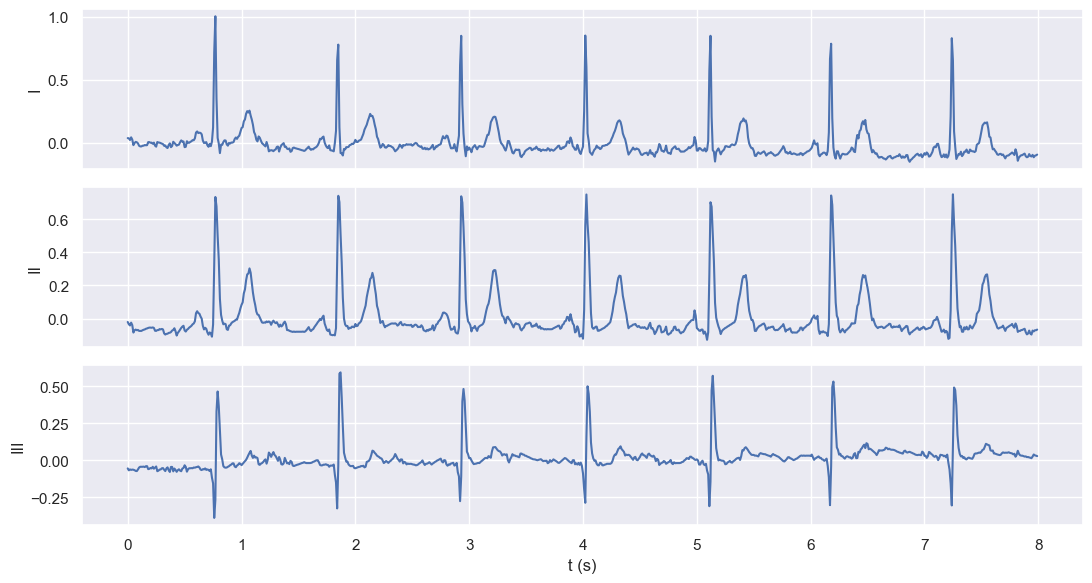

In [7]:
idx = np.random.randint(0, m) # Get ECG random index

fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg_signals[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

## Wander removal

The baseline wander removal process consist on applying a high-pass filter to the ECG data. Lest break down the process as follows:

Let:
- $ \mathbf{X} \in \mathbb{R}^{C \times T \times D} $ represent the ECG tensor, where $ C $ is the number of channels, $ T $ is the number of time points, and $ D $ is the number of trials or instances.
- $ f_s $ is the sampling frequency of the ECG data.
- $ f_c = 0.5 $ Hz is the cutoff frequency for the high-pass filter, chosen to remove baseline wander (typically due to respiration and low-frequency noise).
- $ \text{order} = 4 $ is the order of the Butterworth high-pass filter.

The Butterworth high-pass filter is designed to attenuate signals below the cutoff frequency $ f_c $ while preserving signals at higher frequencies. The following definitions are at the core process:

1. **Normalized Cutoff Frequency**:
   $$
   f_{\text{norm}} = \frac{f_c}{f_s / 2} = \frac{f_c}{f_{\text{Nyquist}}}
   $$
   where $ f_{\text{Nyquist}} = \frac{f_s}{2} $ is the Nyquist frequency.

2. **Butterworth Filter Coefficients**:
   Using the Butterworth filter design of order 4, the filter coefficients $ b $ (numerator) and $ a $ (denominator) for the high-pass filter are calculated to meet this frequency requirement.

   The transfer function of the filter can be written as:
   $$
   H(z) = \frac{b_0 + b_1 z^{-1} + \cdots + b_{\text{order}} z^{-\text{order}}}{a_0 + a_1 z^{-1} + \cdots + a_{\text{order}} z^{-\text{order}}}
   $$

The filter is applied to the ECG signal along the time dimension $ T $ using `filtfilt`, which performs zero-phase filtering by applying the filter forward and backward. This prevents phase distortion and effectively removes low-frequency components (e.g., baseline wander).

For each channel $ c $ and trial $ d $:
The filtered ECG signal $ \mathbf{X}'_{c, t, d} $ is computed by passing $ \mathbf{X}_{c, t, d} $ through the filter:
   $$
   \mathbf{X}'_{c, t, d} = \text{filtfilt}(b, a, \mathbf{X}_{c, :, d})
   $$

### Zero-phase filtering

Zero-phase filtering is a technique used to apply a filter to a signal without introducing phase distortion. Normally, when a filter is applied, the output signal experiences a phase shift, which means that peaks and other features in the signal can be delayed, skewing the original signal. Zero-phase filtering addresses this by performing the filtering operation in a way that cancels out the phase shift.

Here’s how zero-phase filtering works, particularly in the context of **forward-backward filtering** (as done by `filtfilt` in the `scipy.signal` library):

#### Forward Filtering Pass
   - First, a filter (e.g., a Butterworth high-pass filter) is applied to the signal in the usual forward direction.
   - Let’s denote the original signal as $ x[n] $, and the filtered result after this forward pass as $ y_{\text{forward}}[n] $.

   This operation introduces a phase shift, where peaks and features are delayed, as in a normal filtering operation.

#### Reverse the Filtered Signal
   - Next, the resulting signal $ y_{\text{forward}}[n] $ is reversed in time.
   - By reversing the signal, the phase shift caused by the forward filtering pass is also effectively reversed.

#### Backward Filtering Pass
   - Now, the reversed signal $ y_{\text{forward}}[n] $ is filtered again, this time in the backward direction.
   - This second pass reverses the phase shift introduced by the first pass because the signal is reversed back to its original direction.

#### Reverse the Signal Again to Restore Original Time Order
   - After the backward filtering pass, the signal is reversed again, returning it to its original time order.

#### Result: Zero-Phase Shift
   - The combination of a forward pass and a backward pass effectively cancels out the phase shift introduced by each pass.
   - This produces a **zero-phase filter**, meaning the filtered signal aligns perfectly with the original in terms of timing, with no phase distortion.
   - The result is that sharp features, peaks, and other time-based characteristics of the original signal are preserved accurately.

#### Trade-Off: Double Filtering Effect
   - Zero-phase filtering, as implemented in `filtfilt`, applies the filter twice (forward and backward). As a result, the filter’s effect is **squared** in terms of its magnitude response.
   - For example, if a fourth-order filter is used, the resulting filter effect is effectively an eighth-order filter.

#### Mathematical Summary
Let $ H(z) $ represent the transfer function of the filter. When filtering forward and backward, the overall transfer function becomes:
$$
H_{\text{zero-phase}}(z) = H(z) \cdot H(z^{-1})
$$
where $ H(z) $ represents the forward filter, and $ H(z^{-1}) $ represents the backward (reversed) filter. This squared transfer function provides the desired frequency response without introducing a phase shift.

In [8]:
ecg_signals_w0 = preprocessing.wander_removal(ecg_signals, fs, axis=1)

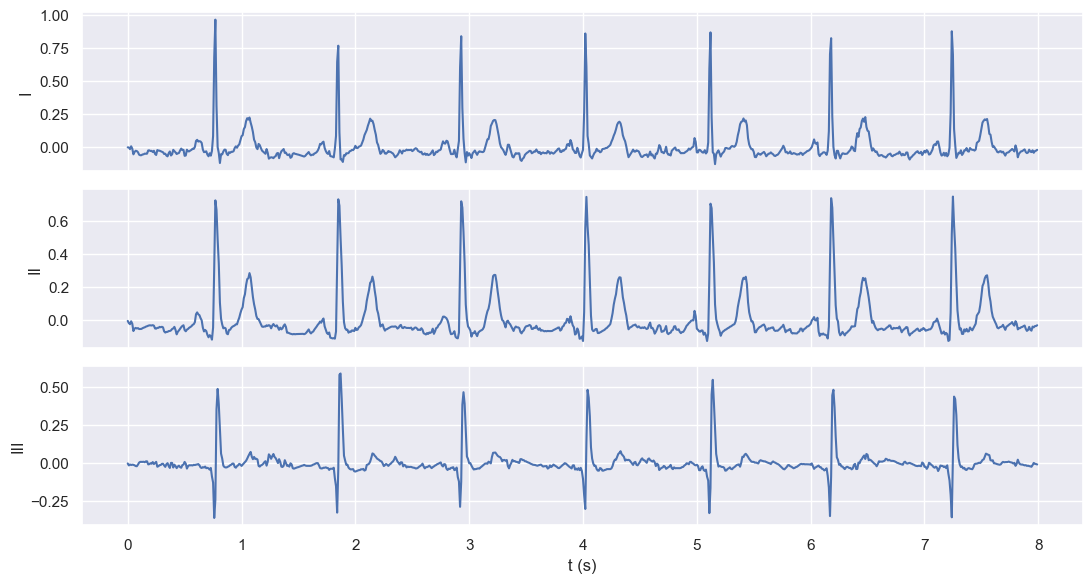

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg_signals_w0[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

## Mean removal

The mean removal operation for a tensor of ECG signals can be expressed as follows: let’s denote the ECG data as a 3D tensor $ \mathbf{X} \in \mathbb{R}^{C \times T \times D} $, where:

- $ C $: number of channels (or leads),
- $ T $: number of time samples (temporal dimension),
- $ D $: number of trials or instances.

Let $ \mathbf{X}_{c, t, d} $ represent a single ECG data point at channel $ c $, time $ t $, and trial $ d $. To remove the mean from each channel and trial across the time dimension, calculate the mean value along the time axis for each $ c $ and $ d $:
$$
\mu_{c,d} = \frac{1}{T} \sum_{t=1}^{T} \mathbf{X}_{c, t, d}
$$
where $ \mu_{c,d} $ is the mean of the signal over time $ T $ for each channel $ c $ and trial $ d $. Then subtract this mean $ \mu_{c,d} $ from each corresponding data point along the time dimension:
$$
\mathbf{X}_{c, t, d}' = \mathbf{X}_{c, t, d} - \mu_{c,d}
$$
where $ \mathbf{X}_{c, t, d}' $ represents the mean-removed ECG data. Putting it all together, the mean removal operation can be represented as:
$$
\mathbf{X}_{c, t, d}' = \mathbf{X}_{c, t, d} - \frac{1}{T} \sum_{t=1}^{T} \mathbf{X}_{c, t, d}
$$

This formula represents the mean removal processing for each time sample $ t $ within each channel $ c $ and trial $ d $ in the 3D tensor.

In [10]:
ecg_signals_m0 = preprocessing.mean_removal(ecg_signals_w0, axis=1)

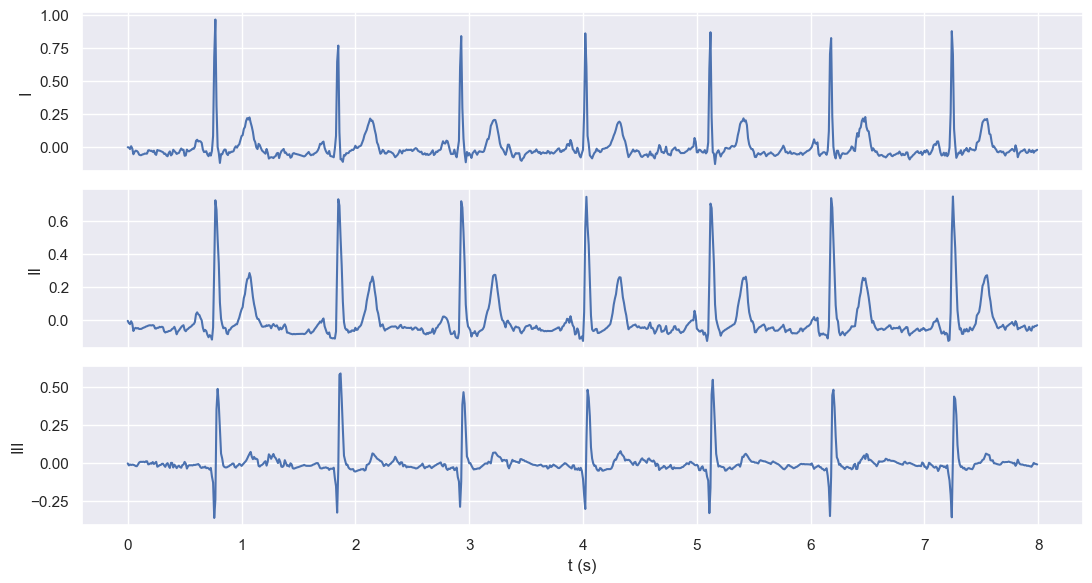

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg_signals_m0[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()

## Pan–Tompkins algorithm

The Pan–Tompkins algorithm is a widely used method for detecting QRS complexes (the characteristic spikes) in ECG signals. It accomplishes this by preprocessing the ECG signal to enhance the QRS complex and reduce noise. The algorithm involves several stages:

### 1. **Bandpass Filtering**: 
   - The goal of bandpass filtering is to remove noise, such as baseline wander and high-frequency noise, while retaining the frequency range where QRS complexes typically occur.
   - Let $ \mathbf{X} $ be the ECG signal, and $ f_s $ be the sampling frequency. In general, the bandpass filter targets frequencies between 5–15 Hz, as the QRS complex lies within this range.
   
   Mathematically, the bandpass-filtered signal $ \mathbf{X}_{\text{BP}} $ can be represented as:
   $$
   \mathbf{X}_{\text{BP}} = H_{\text{BP}}(z) * \mathbf{X}
   $$
   where $ H_{\text{BP}}(z) $ is the transfer function of the bandpass filter, typically designed as a Butterworth or FIR filter. The filtering removes frequencies outside this range, improving signal quality for later stages.

### 2. **Differentiation**:
   - The derivative filter emphasizes regions of the signal with steep slopes, which are characteristic of the QRS complex. This stage helps highlight the rapid changes in amplitude associated with the QRS complex.
   - The differentiation can be implemented as a discrete derivative. For each time point $ n $, the differentiated signal $ \mathbf{X}_{\text{D}} $ can be computed as:
   $$
   \mathbf{X}_{\text{D}}[n] = \frac{1}{8} (2 \mathbf{X}_{\text{BP}}[n] + \mathbf{X}_{\text{BP}}[n-1] - \mathbf{X}_{\text{BP}}[n-3] - 2 \mathbf{X}_{\text{BP}}[n-4])
   $$
   This formula provides a simple difference operation that highlights the QRS slope while suppressing low-frequency components.

### 3. **Squaring**:
   - The squaring operation amplifies the large values (i.e., high slopes) and attenuates smaller ones, which further emphasizes the QRS complex and reduces the influence of low-amplitude noise.
   - For each point $ n $ in the differentiated signal, the squared signal $ \mathbf{X}_{\text{S}} $ is:
   $$
   \mathbf{X}_{\text{S}}[n] = (\mathbf{X}_{\text{D}}[n])^2
   $$
   Squaring ensures all values are positive and highlights significant peaks corresponding to the QRS complex.

### 4. **Smoothing (Moving Window Integration)**:
   - The final step is smoothing, typically by applying a moving window integration (MWI) to smooth out the signal and further enhance the QRS peaks.
   - Using a window $ w $, the smoothed signal $ \mathbf{X}_{\text{MWI}} $ can be computed as:
   $$
   \mathbf{X}_{\text{MWI}}[n] = \frac{1}{w} \sum_{i=0}^{w-1} \mathbf{X}_{\text{S}}[n - i]
   $$
   where $ w $ is the window length, chosen based on the sampling rate to span a typical QRS complex duration (e.g., ~150 ms).
   
The final output, $ \mathbf{X}_{\text{MWI}} $, contains enhanced QRS complexes with reduced noise, making it easier to detect R-peaks.

### Summary of the Pan–Tompkins Algorithm:
The full process can be summarized as:
$$
\mathbf{X}_{\text{MWI}} = \text{MWI} \left( \left( \frac{d}{dt} \left( H_{\text{BP}}(z) * \mathbf{X} \right) \right)^2 \right)
$$
where:
- $ H_{\text{BP}}(z) $ represents the bandpass filter,
- $ \frac{d}{dt} $ is the differentiation,
- $ (\cdot)^2 $ is the squaring operation,
- `MWI` denotes moving window integration.

This final signal, $ \mathbf{X}_{\text{MWI}} $, is used to detect R-peaks by identifying significant peaks that correspond to the QRS complexes in the original ECG signal.

In [12]:
w = int((150/1000)*fs)  # Moving average window size (150ms)
ecg_signals_pt = preprocessing.pan_tompkins(ecg_signals_m0, fs, w, axis=1)

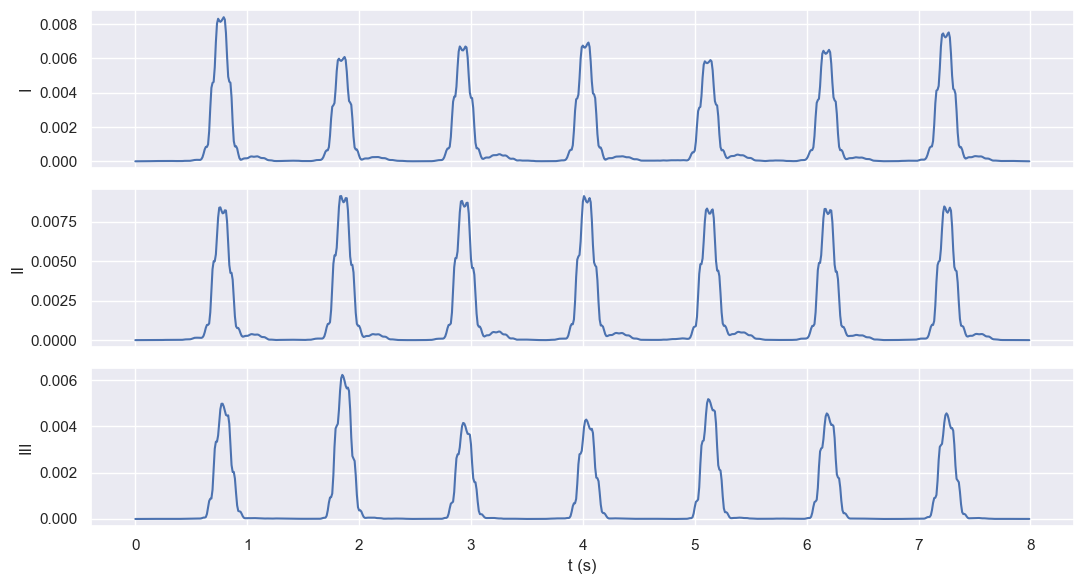

In [13]:
fig, ax = plt.subplots(3, 1, figsize=(11, 6), sharex=True, sharey=False)
for i in range(3):
    ax[i].plot(t, ecg_signals_pt[idx, :, i].ravel())
    ax[i].set_ylabel(leads[i])
ax[i].set_xlabel('t (s)')
plt.tight_layout()
plt.show()